In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Number of units built in each census tract

In [2]:
total_units = pd.read_csv("./data/bayarea_total_units_JG.csv")
total_units.head(5)

,FIPS13,YearBuilt,TotalUnits
0,60013522021051,2001,1
1,60013522021051,2009,1
2,60013530012030,2000,1
3,60013530012041,2004,1
4,60013530012041,2009,1


In [3]:
total_units = total_units.rename(columns={'FIPS13': 'FIPS13', 'YearBuilt': 'year', 'TotalUnits': 'total_units'})

In [4]:
geoid_10 = total_units['FIPS13'].astype(str)
geoid_10 = geoid_10.str.slice(stop=10)
geoid_10.head(5)

0    6001352202
1    6001352202
2    6001353001
3    6001353001
4    6001353001
Name: FIPS13, dtype: object

In [5]:
total_units_geoid = total_units.drop(columns=['FIPS13'])
total_units_geoid['GEO_ID_10'] = geoid_10
total_units_geoid.head(5)

,year,total_units,GEO_ID_10
0,2001,1,6001352202
1,2009,1,6001352202
2,2000,1,6001353001
3,2004,1,6001353001
4,2009,1,6001353001


In [6]:
total_units_geoid['GEO_ID_10'] = total_units_geoid['GEO_ID_10'].str.zfill(11)
total_units_geoid.head(5)

,year,total_units,GEO_ID_10
0,2001,1,06001352202
1,2009,1,06001352202
2,2000,1,06001353001
3,2004,1,06001353001
4,2009,1,06001353001


Changed county for census_tract 35511 to 013 (Contra Costa County).

In [7]:
total_units_geoid.iloc[7, 2] = '0601335511'

In [8]:
total_units_by_tract_by_year = total_units_geoid.groupby(
        by=['GEO_ID_10','year'], 
        axis=0, 
        as_index=False) \
    .sum()
total_units_by_tract_by_year.head(5)

,GEO_ID_10,year,total_units
0,06001352202,2001,1
1,06001352202,2009,1
2,06001353001,2000,1
3,06001353001,2004,1
4,06001353001,2009,1


In [9]:
total_units_2010_2017 = total_units_by_tract_by_year[
                            (total_units_by_tract_by_year['year'] <= 2017) &
                            (total_units_by_tract_by_year['year'] >= 2010)]
total_units_2010_2017.head(5)

,GEO_ID_10,year,total_units
17,06001400100,2010,9
18,06001400100,2011,3
19,06001400100,2012,1
20,06001400100,2013,1
21,06001400100,2014,1


# Converting tracts to zip codes

In [10]:
tract_to_zip_list = []

for i in range(0, 8):
    year = f'201{i}'
    df = pd.read_excel(f'./data/TRACT_ZIP_12{year}.xlsx')
    df.columns = df.columns.str.lower()
    df['tract'] = df['tract'].astype(str).str.zfill(11)
    df['year'] = int(year)
    df = df.drop(columns=['bus_ratio', 'oth_ratio', 'tot_ratio'])
    df = df.rename(columns={'res_ratio': 'resident'})
    tract_to_zip_list.append(df)

In [11]:
tract_to_zip = pd.concat(tract_to_zip_list, axis=0)
tract_to_zip.head(5)

,tract,zip,resident,year
0,01001020100,36067,1.000000,2010
1,01001020200,36008,0.027225,2010
2,01001020200,36067,0.972775,2010
3,01001020300,36067,1.000000,2010
4,01001020400,36066,0.962221,2010


In [12]:
total_units_per_tract = pd.merge(total_units_2010_2017, 
                               tract_to_zip, 
                               left_on=['GEO_ID_10', 'year'], 
                               right_on=['tract', 'year'])
total_units_per_tract.head(5)

,GEO_ID_10,year,total_units,tract,zip,resident
0,06001400100,2010,9,06001400100,94611,0.042201
1,06001400100,2010,9,06001400100,94618,0.287867
2,06001400100,2010,9,06001400100,94704,0.034665
3,06001400100,2010,9,06001400100,94705,0.635267
4,06001400100,2010,9,06001400100,94720,0.000000


In [13]:
total_units_per_tract['units_built'] = total_units_per_tract['total_units'] * total_units_per_tract['resident']
total_units_per_tract.head(5)

,GEO_ID_10,year,total_units,tract,zip,resident,units_built
0,06001400100,2010,9,06001400100,94611,0.042201,0.379804
1,06001400100,2010,9,06001400100,94618,0.287867,2.590803
2,06001400100,2010,9,06001400100,94704,0.034665,0.311982
3,06001400100,2010,9,06001400100,94705,0.635267,5.717403
4,06001400100,2010,9,06001400100,94720,0.000000,0.000000


In [14]:
total_units_per_tract[total_units_per_tract['year'] == 2019].shape

(0, 7)

In [15]:
total_units_per_zip = total_units_per_tract[['year', 'zip', 'units_built']]
total_units_per_zip.head(5)

,year,zip,units_built
0,2010,94611,0.379804
1,2010,94618,2.590803
2,2010,94704,0.311982
3,2010,94705,5.717403
4,2010,94720,0.000000


In [16]:
total_units_by_zip = total_units_per_zip.groupby(by=['zip', 'year'], axis=0, as_index=False).sum()
total_units_by_zip.head(5)

,zip,year,units_built
0,94002,2010,3.012672
1,94002,2011,4.007986
2,94002,2012,3.152709
3,94002,2013,3.961284
4,94002,2014,3.000000


In [17]:
total_units_by_zip['units_built'] = total_units_by_zip['units_built'].apply(np.round).astype(int)
total_units_by_zip.head(5)

,zip,year,units_built
0,94002,2010,3
1,94002,2011,4
2,94002,2012,3
3,94002,2013,4
4,94002,2014,3


# Housing Prices

In [18]:
zillow = pd.read_csv('./data/zillow.csv')

In [19]:
zillow.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,227153.0,...,1091641.0,1087154.0,1085121.0,1086397.0,1082450.0,1078831.0,1074640.0,1066881.0,1069011.0,1073214.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,212230.0,...,497724.0,499152.0,501262.0,504040.0,506695.0,509141.0,511452.0,513457.0,515542.0,516747.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,200946.0,...,998619.0,998643.0,1001866.0,1013305.0,1016169.0,1014689.0,1009092.0,1011561.0,1021442.0,1029770.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201011.0,...,339450.0,340170.0,341602.0,343191.0,345709.0,348800.0,353185.0,357460.0,362468.0,367829.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,283626.0,...,635967.0,637199.0,638751.0,641622.0,644350.0,647291.0,650118.0,652578.0,655761.0,658233.0


In [20]:
zillow = zillow.drop(columns=['RegionID', 
                              'SizeRank', 
                              'RegionType', 
                              'StateName', 
                              'State', 
                              'City', 
                              'Metro', 
                              'CountyName'])
zillow.head(5)

,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,...,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31
0,10025,227153.0,225738.0,225814.0,225790.0,226306.0,226934.0,226823.0,227619.0,227965.0,...,1091641.0,1087154.0,1085121.0,1086397.0,1082450.0,1078831.0,1074640.0,1066881.0,1069011.0,1073214.0
1,60657,212230.0,212073.0,211661.0,211524.0,210956.0,211141.0,210927.0,211539.0,212435.0,...,497724.0,499152.0,501262.0,504040.0,506695.0,509141.0,511452.0,513457.0,515542.0,516747.0
2,10023,200946.0,200989.0,201100.0,201816.0,202857.0,203710.0,203994.0,204078.0,204399.0,...,998619.0,998643.0,1001866.0,1013305.0,1016169.0,1014689.0,1009092.0,1011561.0,1021442.0,1029770.0
3,77494,201011.0,201259.0,201062.0,199869.0,198728.0,198060.0,198825.0,198512.0,197857.0,...,339450.0,340170.0,341602.0,343191.0,345709.0,348800.0,353185.0,357460.0,362468.0,367829.0
4,60614,283626.0,283367.0,282845.0,282702.0,282021.0,282109.0,281613.0,282177.0,283263.0,...,635967.0,637199.0,638751.0,641622.0,644350.0,647291.0,650118.0,652578.0,655761.0,658233.0


In [21]:
zillow_q4 = zillow[[zillow.columns[0]] + [col for col in zillow.columns if '-12-' in col]]
zillow_q4.head(5)

,RegionName,1996-12-31,1997-12-31,1998-12-31,1999-12-31,2000-12-31,2001-12-31,2002-12-31,2003-12-31,2004-12-31,...,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31
0,10025,232288.0,249559.0,297409.0,365222.0,457899.0,537778.0,590102.0,706128.0,811054.0,...,917022.0,952211.0,1044071.0,1183382.0,1260988.0,1299640.0,1207579.0,1268144.0,1184383.0,1074640.0
1,60657,216901.0,220413.0,248569.0,282386.0,326790.0,361820.0,382506.0,397071.0,419766.0,...,398085.0,396617.0,450111.0,460604.0,467852.0,491532.0,496357.0,503865.0,491195.0,511452.0
2,10023,206659.0,229875.0,251912.0,279682.0,332722.0,382766.0,424800.0,488220.0,556784.0,...,766144.0,792216.0,873578.0,971943.0,1027807.0,1046132.0,1033575.0,1023463.0,966318.0,1009092.0
3,77494,199658.0,215038.0,207634.0,219026.0,227440.0,228291.0,228549.0,235857.0,247465.0,...,262289.0,269758.0,301976.0,330015.0,340156.0,331932.0,333138.0,337393.0,337232.0,353185.0
4,60614,289462.0,291350.0,325137.0,364159.0,417792.0,456994.0,484111.0,498849.0,525347.0,...,501378.0,503722.0,571893.0,591076.0,611218.0,635666.0,641008.0,650355.0,634193.0,650118.0


In [22]:
zillow_2010_2019 = zillow_q4[[zillow.columns[0]] + 
                             [col for col in zillow_q4.columns if '2010' <= col[:4] < '2020']]
zillow_2010_2019.head(5)

,RegionName,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31
0,10025,907964.0,917022.0,952211.0,1044071.0,1183382.0,1260988.0,1299640.0,1207579.0,1268144.0,1184383.0
1,60657,412886.0,398085.0,396617.0,450111.0,460604.0,467852.0,491532.0,496357.0,503865.0,491195.0
2,10023,725539.0,766144.0,792216.0,873578.0,971943.0,1027807.0,1046132.0,1033575.0,1023463.0,966318.0
3,77494,265354.0,262289.0,269758.0,301976.0,330015.0,340156.0,331932.0,333138.0,337393.0,337232.0
4,60614,518787.0,501378.0,503722.0,571893.0,591076.0,611218.0,635666.0,641008.0,650355.0,634193.0


In [23]:
zillow_years = []

for i in range(10):
    year = f'201{i}'
    df = zillow_2010_2019[['RegionName', f'{year}-12-31']]
    df = df.rename(columns={'RegionName': 'zip', f'{year}-12-31': 'price'})
    df['year'] = int(year)
    zillow_years.append(df)

zillow_by_year = pd.concat(zillow_years, axis=0)
zillow_by_year.head(5)

,zip,price,year
0,10025,907964.0,2010
1,60657,412886.0,2010
2,10023,725539.0,2010
3,77494,265354.0,2010
4,60614,518787.0,2010


# Housing Prices with Housing Units built

In [24]:
data = pd.merge(total_units_by_zip, zillow_by_year, left_on=['zip', 'year'], right_on=['zip', 'year'])
data

,zip,year,units_built,price
0,94002,2010,3,887752.0
1,94002,2011,4,877332.0
2,94002,2012,3,995829.0
3,94002,2013,4,1243884.0
4,94002,2014,3,1363204.0
...,...,...,...,...
2102,95694,2013,1,309138.0
2103,95694,2014,2,346545.0
2104,95694,2015,1,375418.0
2105,95694,2016,0,412691.0


In [25]:
data_2010 = data[data['year'] == 2010]
data_2010.head(5)

,zip,year,units_built,price
0,94002,2010,3,887752.0
7,94005,2010,4,566928.0
13,94010,2010,30,1318145.0
20,94014,2010,209,540374.0
28,94015,2010,1,531530.0


In [26]:
data_2010.to_csv('./data-out/data_2010.csv')

# Housing Units Per Year

In [27]:
data[['year', 'units_built']].groupby(by=['year']).sum()

,units_built
year,
2010,6810
2011,4128
2012,8661
2013,12934
2014,13929
2015,13817
2016,15408
2017,18013


In [28]:
data[data['year'] == 2018].shape

(0, 4)

In [29]:
data[data['year'] == 2010].shape

(259, 4)

In [30]:
zillow_2010_2019

,RegionName,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31
0,10025,907964.0,917022.0,952211.0,1044071.0,1183382.0,1260988.0,1299640.0,1207579.0,1268144.0,1184383.0
1,60657,412886.0,398085.0,396617.0,450111.0,460604.0,467852.0,491532.0,496357.0,503865.0,491195.0
2,10023,725539.0,766144.0,792216.0,873578.0,971943.0,1027807.0,1046132.0,1033575.0,1023463.0,966318.0
3,77494,265354.0,262289.0,269758.0,301976.0,330015.0,340156.0,331932.0,333138.0,337393.0,337232.0
4,60614,518787.0,501378.0,503722.0,571893.0,591076.0,611218.0,635666.0,641008.0,650355.0,634193.0
...,...,...,...,...,...,...,...,...,...,...,...
30292,12345,108388.0,101604.0,99697.0,112344.0,106899.0,117048.0,126059.0,131816.0,144852.0,148928.0
30293,75599,44562.0,45786.0,47766.0,45371.0,46730.0,46439.0,45825.0,48814.0,45091.0,47494.0
30294,1470,NaN,NaN,347475.0,347300.0,331550.0,345055.0,349892.0,362373.0,367161.0,393894.0
30295,822,NaN,NaN,NaN,136208.0,149952.0,155218.0,170456.0,173603.0,189003.0,199141.0


In [31]:
zip_codes = pd.read_csv('./data/bay_area_zip_codes.csv')

In [32]:
zip_codes

,Zip Codes,County,State,Area,City
0,94102,San Francisco County,California,Bay Area,NaN
1,94103,San Francisco County,California,Bay Area,NaN
2,94104,San Francisco County,California,Bay Area,NaN
3,94105,San Francisco County,California,Bay Area,NaN
4,94107,San Francisco County,California,Bay Area,NaN
...,...,...,...,...,...
474,95043,San Benito,California,12-county Combined Statistical Area,NaN
475,95024,San Benito,California,12-county Combined Statistical Area,NaN
476,95023,San Benito,California,12-county Combined Statistical Area,NaN
477,93930,San Benito,California,12-county Combined Statistical Area,NaN


In [33]:
bay_area_zip_codes = list(zip_codes['Zip Codes'])

In [34]:
zillow_bay = zillow_2010_2019[zillow_2010_2019['RegionName'].isin(bay_area_zip_codes)]
zillow_bay = zillow_bay.reset_index().drop(columns=['index'])
zillow_bay.head(5)

,RegionName,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31
0,94109,772909.0,747113.0,856997.0,968958.0,1020231.0,1163282.0,1115682.0,1162264.0,1194078.0,1221178.0
1,94565,283287.0,300174.0,354926.0,428580.0,475806.0,491285.0,525957.0,564190.0,590716.0,587064.0
2,94501,507998.0,486283.0,548960.0,680398.0,721427.0,823707.0,877386.0,973741.0,1045963.0,1077779.0
3,94110,830192.0,808865.0,925853.0,1105195.0,1278243.0,1438728.0,1437001.0,1510650.0,1610837.0,1631369.0
4,94558,422762.0,369419.0,423200.0,526375.0,554726.0,605605.0,649830.0,667422.0,710722.0,700421.0


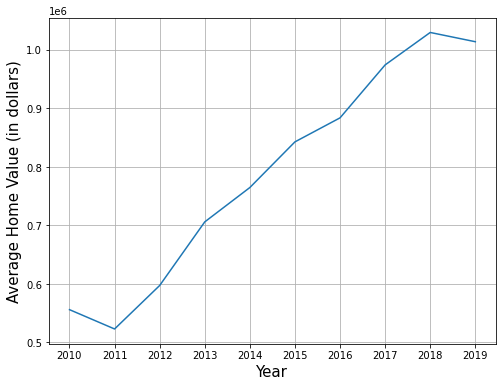

In [35]:
xlabels = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
avg_bay_price = list(zillow_bay.iloc[:, 1:].mean(axis=0))

plt.figure(figsize=(8, 6))
plt.plot(avg_bay_price)
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Average Home Value (in dollars)", fontsize=15)
plt.grid()
plt.savefig('./out/images/bay_area_housing.png', dpi=800)
plt.show();

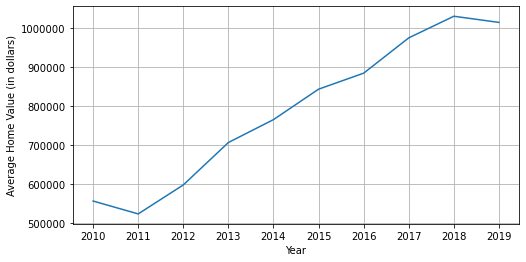

In [75]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(avg_bay_price)
ax.ticklabel_format(style='plain') #This is the line you need <-------
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.xlabel("Year")
plt.ylabel("Average Home Value (in dollars)")
plt.grid()
fig.savefig('./out/images/bay_area_housing.png', dpi=300)
fig.show()

In [42]:
prices_county = pd.merge(zillow_2010_2019, 
                zip_codes[['Zip Codes', 'County']], 
                left_on=['RegionName'], 
                right_on=['Zip Codes']).drop(columns=['RegionName'])
prices_county.head(5)

,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,Zip Codes,County
0,772909.0,747113.0,856997.0,968958.0,1020231.0,1163282.0,1115682.0,1162264.0,1194078.0,1221178.0,94109,San Francisco County
1,772909.0,747113.0,856997.0,968958.0,1020231.0,1163282.0,1115682.0,1162264.0,1194078.0,1221178.0,94109,Sonoma County
2,283287.0,300174.0,354926.0,428580.0,475806.0,491285.0,525957.0,564190.0,590716.0,587064.0,94565,Alameda County
3,283287.0,300174.0,354926.0,428580.0,475806.0,491285.0,525957.0,564190.0,590716.0,587064.0,94565,Sonoma County
4,283287.0,300174.0,354926.0,428580.0,475806.0,491285.0,525957.0,564190.0,590716.0,587064.0,94565,Solana County


In [45]:
prices_by_county = prices_county.groupby(by=['County'], axis=0, as_index=False).mean()
prices_by_county

,County,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,Zip Codes
0,Alameda County,464161.250000,436129.205882,495578.058824,6.149423e+05,6.623184e+05,7.502517e+05,8.073752e+05,8.947170e+05,9.539510e+05,9.472095e+05,94669.205882
1,Contra Costa County,541430.121212,508904.176471,565917.176471,6.550810e+05,6.967449e+05,7.452934e+05,7.714518e+05,8.234664e+05,8.719759e+05,8.660314e+05,94578.210526
2,Marin County,744308.500000,682448.459459,789161.743590,9.106254e+05,9.783941e+05,1.086893e+06,1.149109e+06,1.252156e+06,1.300754e+06,1.309784e+06,94792.358974
3,Napa County,429671.533333,383347.866667,415401.333333,5.062523e+05,5.260864e+05,5.759567e+05,6.254208e+05,6.583342e+05,7.120032e+05,7.121726e+05,94796.187500
4,San Benito,425430.857143,397305.714286,421060.571429,5.066061e+05,5.363605e+05,5.759250e+05,6.084401e+05,6.292290e+05,6.607154e+05,6.474628e+05,94668.750000
5,San Francisco County,811232.200000,775383.680000,897268.120000,1.035264e+06,1.150187e+06,1.315155e+06,1.308317e+06,1.390005e+06,1.487146e+06,1.517045e+06,94118.240000
6,San Joaquin County,217570.372093,199608.302326,224226.558140,2.817989e+05,3.054318e+05,3.298128e+05,3.595455e+05,3.925069e+05,4.233171e+05,4.296190e+05,95262.386364
7,San Mateo County,780252.755556,762985.155556,885640.217391,1.068184e+06,1.150481e+06,1.306467e+06,1.358470e+06,1.506943e+06,1.594272e+06,1.558394e+06,91596.659574
8,Santa Clara County,784650.236364,741619.600000,877379.145455,1.008340e+06,1.124616e+06,1.205485e+06,1.253861e+06,1.455647e+06,1.551582e+06,1.457826e+06,94869.800000
9,Santa Cruz County,595376.600000,555417.400000,647265.238095,7.440715e+05,7.927547e+05,8.370190e+05,8.883749e+05,9.629450e+05,1.001749e+06,9.703888e+05,94989.809524


In [48]:
prices_by_county.sort_values(['2010-12-31'], ascending=False)

,County,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,Zip Codes
5,San Francisco County,811232.200000,775383.680000,897268.120000,1.035264e+06,1.150187e+06,1.315155e+06,1.308317e+06,1.390005e+06,1.487146e+06,1.517045e+06,94118.240000
8,Santa Clara County,784650.236364,741619.600000,877379.145455,1.008340e+06,1.124616e+06,1.205485e+06,1.253861e+06,1.455647e+06,1.551582e+06,1.457826e+06,94869.800000
7,San Mateo County,780252.755556,762985.155556,885640.217391,1.068184e+06,1.150481e+06,1.306467e+06,1.358470e+06,1.506943e+06,1.594272e+06,1.558394e+06,91596.659574
2,Marin County,744308.500000,682448.459459,789161.743590,9.106254e+05,9.783941e+05,1.086893e+06,1.149109e+06,1.252156e+06,1.300754e+06,1.309784e+06,94792.358974
9,Santa Cruz County,595376.600000,555417.400000,647265.238095,7.440715e+05,7.927547e+05,8.370190e+05,8.883749e+05,9.629450e+05,1.001749e+06,9.703888e+05,94989.809524
1,Contra Costa County,541430.121212,508904.176471,565917.176471,6.550810e+05,6.967449e+05,7.452934e+05,7.714518e+05,8.234664e+05,8.719759e+05,8.660314e+05,94578.210526
11,Sonoma County,465056.652174,423403.297872,460095.851064,5.370619e+05,5.816273e+05,6.251061e+05,6.577627e+05,7.150985e+05,7.362168e+05,7.273246e+05,93497.229167
0,Alameda County,464161.250000,436129.205882,495578.058824,6.149423e+05,6.623184e+05,7.502517e+05,8.073752e+05,8.947170e+05,9.539510e+05,9.472095e+05,94669.205882
3,Napa County,429671.533333,383347.866667,415401.333333,5.062523e+05,5.260864e+05,5.759567e+05,6.254208e+05,6.583342e+05,7.120032e+05,7.121726e+05,94796.187500
4,San Benito,425430.857143,397305.714286,421060.571429,5.066061e+05,5.363605e+05,5.759250e+05,6.084401e+05,6.292290e+05,6.607154e+05,6.474628e+05,94668.750000


In [58]:
print(prices_by_county.sort_values(['2010-12-31'], ascending=False)[['County', '2010-12-31']].round(2).head(5).to_html(classes='table table-hstriped table-bordered table-hover', index=False))

<table border="1" class="dataframe table table-hstriped table-bordered table-hover">
  <thead>
    <tr style="text-align: right;">
      <th>County</th>
      <th>2010-12-31</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>San Francisco County</td>
      <td>811232.20</td>
    </tr>
    <tr>
      <td>Santa Clara County</td>
      <td>784650.24</td>
    </tr>
    <tr>
      <td>San Mateo County</td>
      <td>780252.76</td>
    </tr>
    <tr>
      <td>Marin County</td>
      <td>744308.50</td>
    </tr>
    <tr>
      <td>Santa Cruz County</td>
      <td>595376.60</td>
    </tr>
  </tbody>
</table>


In [59]:
zillow.head(5)

,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,...,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31
0,10025,227153.0,225738.0,225814.0,225790.0,226306.0,226934.0,226823.0,227619.0,227965.0,...,1091641.0,1087154.0,1085121.0,1086397.0,1082450.0,1078831.0,1074640.0,1066881.0,1069011.0,1073214.0
1,60657,212230.0,212073.0,211661.0,211524.0,210956.0,211141.0,210927.0,211539.0,212435.0,...,497724.0,499152.0,501262.0,504040.0,506695.0,509141.0,511452.0,513457.0,515542.0,516747.0
2,10023,200946.0,200989.0,201100.0,201816.0,202857.0,203710.0,203994.0,204078.0,204399.0,...,998619.0,998643.0,1001866.0,1013305.0,1016169.0,1014689.0,1009092.0,1011561.0,1021442.0,1029770.0
3,77494,201011.0,201259.0,201062.0,199869.0,198728.0,198060.0,198825.0,198512.0,197857.0,...,339450.0,340170.0,341602.0,343191.0,345709.0,348800.0,353185.0,357460.0,362468.0,367829.0
4,60614,283626.0,283367.0,282845.0,282702.0,282021.0,282109.0,281613.0,282177.0,283263.0,...,635967.0,637199.0,638751.0,641622.0,644350.0,647291.0,650118.0,652578.0,655761.0,658233.0


In [61]:
zillow[['2010-12-31']].mean()

2010-12-31    174177.586
dtype: float64

In [62]:
prices_by_county[['2010-12-31']].mean()

2010-12-31    545089.775008
dtype: float64

In [70]:
print(prices_by_county.sort_values(['2019-12-31'], ascending=False)[['County', '2019-12-31']].round(2).head(5).to_html(classes='table table-hstriped table-bordered table-hover', index=False))

<table border="1" class="dataframe table table-hstriped table-bordered table-hover">
  <thead>
    <tr style="text-align: right;">
      <th>County</th>
      <th>2019-12-31</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>San Mateo County</td>
      <td>1558393.85</td>
    </tr>
    <tr>
      <td>San Francisco County</td>
      <td>1517045.08</td>
    </tr>
    <tr>
      <td>Santa Clara County</td>
      <td>1457826.18</td>
    </tr>
    <tr>
      <td>Marin County</td>
      <td>1309784.03</td>
    </tr>
    <tr>
      <td>Santa Cruz County</td>
      <td>970388.81</td>
    </tr>
  </tbody>
</table>


In [71]:
zillow[['2019-12-31']].mean()

2019-12-31    227881.808265
dtype: float64

In [72]:
prices_by_county[['2019-12-31']].mean()

2019-12-31    971470.338505
dtype: float64

,County,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,Zip Codes
0,Alameda County,464161.250000,436129.205882,495578.058824,6.149423e+05,6.623184e+05,7.502517e+05,8.073752e+05,8.947170e+05,9.539510e+05,9.472095e+05,94669.205882
1,Contra Costa County,541430.121212,508904.176471,565917.176471,6.550810e+05,6.967449e+05,7.452934e+05,7.714518e+05,8.234664e+05,8.719759e+05,8.660314e+05,94578.210526
2,Marin County,744308.500000,682448.459459,789161.743590,9.106254e+05,9.783941e+05,1.086893e+06,1.149109e+06,1.252156e+06,1.300754e+06,1.309784e+06,94792.358974
3,Napa County,429671.533333,383347.866667,415401.333333,5.062523e+05,5.260864e+05,5.759567e+05,6.254208e+05,6.583342e+05,7.120032e+05,7.121726e+05,94796.187500
4,San Benito,425430.857143,397305.714286,421060.571429,5.066061e+05,5.363605e+05,5.759250e+05,6.084401e+05,6.292290e+05,6.607154e+05,6.474628e+05,94668.750000
5,San Francisco County,811232.200000,775383.680000,897268.120000,1.035264e+06,1.150187e+06,1.315155e+06,1.308317e+06,1.390005e+06,1.487146e+06,1.517045e+06,94118.240000
6,San Joaquin County,217570.372093,199608.302326,224226.558140,2.817989e+05,3.054318e+05,3.298128e+05,3.595455e+05,3.925069e+05,4.233171e+05,4.296190e+05,95262.386364
7,San Mateo County,780252.755556,762985.155556,885640.217391,1.068184e+06,1.150481e+06,1.306467e+06,1.358470e+06,1.506943e+06,1.594272e+06,1.558394e+06,91596.659574
8,Santa Clara County,784650.236364,741619.600000,877379.145455,1.008340e+06,1.124616e+06,1.205485e+06,1.253861e+06,1.455647e+06,1.551582e+06,1.457826e+06,94869.800000
9,Santa Cruz County,595376.600000,555417.400000,647265.238095,7.440715e+05,7.927547e+05,8.370190e+05,8.883749e+05,9.629450e+05,1.001749e+06,9.703888e+05,94989.809524


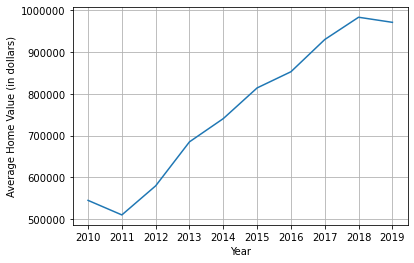

In [129]:
xlabels = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
avg_bay_price = list(prices_by_county.iloc[:, 1:-1].mean(axis=0))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(avg_bay_price)
ax.ticklabel_format(style='plain') #This is the line you need <-------
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.xlabel("Year")
plt.ylabel("Average Home Value (in dollars)")
plt.grid()
fig.savefig('./out/images/bay_area_housing.png', dpi=300, bbox_inches='tight')
fig.show()

In [79]:
avg_bay_price

[545089.7750080551,
 510260.2166049166,
 579931.7480627651,
 685318.0370356274,
 740979.37540545,
 814434.4674582203,
 853181.3774113897,
 930332.9486709437,
 983683.6213112875,
 971470.3385047648]

In [114]:
xlabels = ['2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', 
           '2015-2016', '2016-2017', '2017-2018', '2018-2019']

percent_increase = [(avg_bay_price[i+1] - avg_bay_price[i])/avg_bay_price[i] * 100 for i in range(len(avg_bay_price)-1)]

In [115]:
x = np.arange(len(percent_increase)).reshape(-1, 1)
y = np.array(percent_increase).reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)
x_new = np.linspace(0, len(percent_increase), 100)
y_new = model.predict(x_new[:, np.newaxis])

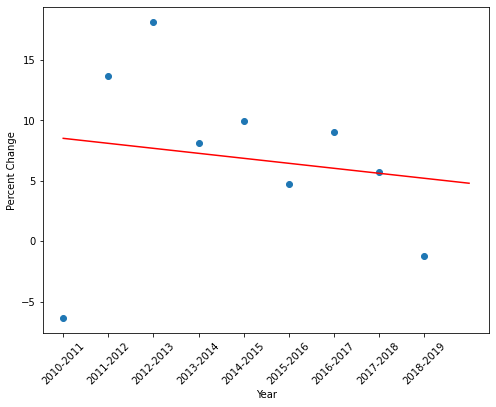

In [122]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(np.arange(len(percent_increase)), percent_increase)
ax.plot(x_new, y_new, color='red')
ax.ticklabel_format(style='plain') #This is the line you need <-------
plt.xticks(np.arange(len(xlabels)), xlabels, rotation=45)
plt.xlabel("Year")
plt.ylabel("Percent Change")
fig.savefig('./out/images/bay_area_housing_percent_change.png', dpi=300, bbox_inches='tight')
fig.show()

In [132]:
model.coef_

array([[-0.41315668]])

In [133]:
total_units_by_zip

,zip,year,units_built
0,94002,2010,3
1,94002,2011,4
2,94002,2012,3
3,94002,2013,4
4,94002,2014,3
...,...,...,...
2421,95694,2014,2
2422,95694,2015,1
2423,95694,2016,0
2424,95694,2017,1


In [139]:
units_by_county = pd.merge(total_units_by_zip, zip_codes.iloc[:, :2], left_on='zip', right_on='Zip Codes') \
                        .drop(columns=['Zip Codes'])
units_by_county.head(5)

,zip,year,units_built,County
0,94002,2010,3,San Mateo County
1,94002,2011,4,San Mateo County
2,94002,2012,3,San Mateo County
3,94002,2013,4,San Mateo County
4,94002,2014,3,San Mateo County


In [160]:
units_county = units_by_county[['year', 'units_built', 'County']].groupby(
                    by=['year', 'County'],
                    axis=0,
                    as_index=False).sum()
units_county.head(5)

,year,County,units_built
0,2010,Alameda County,3456
1,2010,Contra Costa County,212
2,2010,Marin County,382
3,2010,Napa County,120
4,2010,San Benito,16


In [159]:
print(units_county[units_county['year'] == 2017].sort_values(['units_built'], ascending=False).head(5)[['County', 'units_built']].to_html(classes='table table-striped table-bordered table-hover', index=False))

<table border="1" class="dataframe table table-striped table-bordered table-hover">
  <thead>
    <tr style="text-align: right;">
      <th>County</th>
      <th>units_built</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Santa Clara County</td>
      <td>7553</td>
    </tr>
    <tr>
      <td>San Francisco County</td>
      <td>4169</td>
    </tr>
    <tr>
      <td>Alameda County</td>
      <td>3380</td>
    </tr>
    <tr>
      <td>Contra Costa County</td>
      <td>2716</td>
    </tr>
    <tr>
      <td>San Mateo County</td>
      <td>2066</td>
    </tr>
  </tbody>
</table>


In [171]:
units_2010 = units_county[units_county['year'] == 2010]
units_2017 = units_county[units_county['year'] == 2017]
units_2010

,year,County,units_built
0,2010,Alameda County,3456
1,2010,Contra Costa County,212
2,2010,Marin County,382
3,2010,Napa County,120
4,2010,San Benito,16
5,2010,San Francisco County,799
6,2010,San Joaquin County,2
7,2010,San Mateo County,1013
8,2010,Santa Clara County,1292
9,2010,Santa Cruz County,333


In [172]:
units_2017

,year,County,units_built
84,2017,Alameda County,3380
85,2017,Contra Costa County,2716
86,2017,Marin County,820
87,2017,Napa County,176
88,2017,San Benito,112
89,2017,San Francisco County,4169
90,2017,San Joaquin County,918
91,2017,San Mateo County,2066
92,2017,Santa Clara County,7553
93,2017,Santa Cruz County,1410


In [177]:
units_2010_2017 = pd.merge(units_2010, units_2017, left_on=['County'], right_on=['County'])
units_2010_2017.head(5)

,year_x,County,units_built_x,year_y,units_built_y
0,2010,Alameda County,3456,2017,3380
1,2010,Contra Costa County,212,2017,2716
2,2010,Marin County,382,2017,820
3,2010,Napa County,120,2017,176
4,2010,San Benito,16,2017,112


In [178]:
units_2010_2017['increase'] = (units_2010_2017['units_built_y'] - units_2010_2017['units_built_x']) / units_2010_2017['units_built_x'] * 100

In [184]:
units_2010_2017

,year_x,County,units_built_x,year_y,units_built_y,increase
0,2010,Alameda County,3456,2017,3380,-2.199074
1,2010,Contra Costa County,212,2017,2716,1181.132075
2,2010,Marin County,382,2017,820,114.659686
3,2010,Napa County,120,2017,176,46.666667
4,2010,San Benito,16,2017,112,600.000000
5,2010,San Francisco County,799,2017,4169,421.777222
6,2010,San Joaquin County,2,2017,918,45800.000000
7,2010,San Mateo County,1013,2017,2066,103.948667
8,2010,Santa Clara County,1292,2017,7553,484.597523
9,2010,Santa Cruz County,333,2017,1410,323.423423


In [182]:
print(units_2010_2017[['County', 'increase']].to_html(classes='table table-striped table-bordered table-hover', index=False))

<table border="1" class="dataframe table table-striped table-bordered table-hover">
  <thead>
    <tr style="text-align: right;">
      <th>County</th>
      <th>increase</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Alameda County</td>
      <td>-2.199074</td>
    </tr>
    <tr>
      <td>Contra Costa County</td>
      <td>1181.132075</td>
    </tr>
    <tr>
      <td>Marin County</td>
      <td>114.659686</td>
    </tr>
    <tr>
      <td>Napa County</td>
      <td>46.666667</td>
    </tr>
    <tr>
      <td>San Benito</td>
      <td>600.000000</td>
    </tr>
    <tr>
      <td>San Francisco County</td>
      <td>421.777222</td>
    </tr>
    <tr>
      <td>San Joaquin County</td>
      <td>45800.000000</td>
    </tr>
    <tr>
      <td>San Mateo County</td>
      <td>103.948667</td>
    </tr>
    <tr>
      <td>Santa Clara County</td>
      <td>484.597523</td>
    </tr>
    <tr>
      <td>Santa Cruz County</td>
      <td>323.423423</td>
    </tr>
    <tr>
      <td>Solana C

In [187]:
units_2010['units_built'].sum()

8509

In [188]:
(25000-8000)/8000 * 100

212.5

In [ ]:
units_2010_2017['increase'] = (units_2010_2017['units_built_y'] - units_2010_2017['units_built_x']) / units_2010_2017['units_built_x'] * 100